# Combining partially mactched Targets #1 and #3

The purpose of this notebook is to look at generate simple models for Cas13d binding 

In [1]:
import numpy as np
import pandas as pd
import edit_distance
from sklearn import linear_model, preprocessing
from sklearn.linear_model import HuberRegressor, Ridge
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib_venn import venn3, venn3_circles
from scipy.stats import pearsonr
import yaml
import RNA
import h5py
from uncertainties import ufloat
from uncertainties.umath import log
from scipy import stats

## Loading in the data

In [43]:
#define target seqeunce #1, #3, prefix and 
target1 = 'CCATAGAGAGGTTATCCGCTCA'
target3 = 'TTTGATCTGAAATATTCAGGTC'
target1_prefix = 'GGGAATGGATCCACATCTACGAATTCGTA'
target1_suffix = 'CCGAGATCGGAAGAGCACACGT'
target3_prefix = 'GGGAATGGATCCACATCTACGAATTCGTT'
target3_suffix = 'TGCAGATCGGAAGAGCACACGT'

print 'target4 prefix length: %s' %len(target4_prefix[:])
print 'target4 suffix length: %s' %len(target4_suffix[:])

target4: CCATAGAGAGGTTATCCGCTCA
target7: TTTGATCTGAAATATTCAGGTC
target4 prefix length: 29
target4 suffix length: 22


In [8]:
def structure_cr4(sequence):
    ss,mfe = RNA.fold((target4_prefix[:]+sequence+target4_suffix[:]).replace('T', 'U'))
    RNA_seq = (target4_prefix[:]+sequence+target4_suffix[:]).replace('T', 'U')
    return RNA_seq[29:-22],ss[29:-22],mfe
def structure_cr7(sequence):
    ss,mfe = RNA.fold((target7_prefix[:]+sequence+target7_suffix[:]).replace('T', 'U'))
    RNA_seq = (target7_prefix[:]+sequence+target7_suffix[:]).replace('T', 'U')
    return RNA_seq[29:-22],ss[29:-22],mfe

In [9]:
TRIAL_1_PATH4 = '/mnt/agate/hdd3/home/jami/notebooks/model_cas13d/final_target4.csv'
TRIAL_1_PATH7 = '/mnt/agate/hdd3/home/jami/notebooks/model_cas13d/final_target7_new.csv'

In [10]:
df4 = pd.read_csv(TRIAL_1_PATH4)
df7 = pd.read_csv(TRIAL_1_PATH7)

In [11]:
df4.head() #find the matched target delta_y = bound and filter those <.2*bound

,sequence,structure,mfe,ABA_normalized
0,GGGAATGGATCCACATCTACGAATTCGTACCATAGAGAGGTTTAGG...,.........(((..((((.((...(((((((.......)))....)...,-10.600000,0.628832
1,GGGAATGGATCCACATCTACGAATTCGTACCATAGAAGGTTATCCG...,((((.(((((...(.((((((....))).....))).)...)))))...,-14.100000,0.109211
2,GGGAATGGATCCACATCTACGAATTCGTACCATAGAGAGGTTTATC...,((((.((((((....((((((....))).....)))..))))))))...,-19.299999,0.462700
3,GGGAATGGATCCACATCTACGAATTCGTACCATAGAAGGTTATCCG...,.((.((((((.(........).)))))).))......((....))(...,-11.300000,0.277148
4,GGGAATGGATCCACATCTACGAATTCGTACGCATAGAGAGGTTATC...,......((((((...((((((........))..))))..))..)))...,-14.400000,0.349502


### Just Target 4 Combination

In [12]:
perfect_sequence4 = 'GGGAATGGATCCACATCTACGAATTCGTA' + 'CCATAGAGAGGTTATCCGCTCA' + 'CCGAGATCGGAAGAGCACACGT'
perfect_target4 = 'CCATAGAGAGGTTATCCGCTCA'
#PERFECT_KD1 = df4_1[df4_1['sequence'] == perfect_sequence4].iloc[0]['kd']
#PERFECT_KD2 = df4_2[df4_2['sequence'] == perfect_sequence4].iloc[0]['kd']

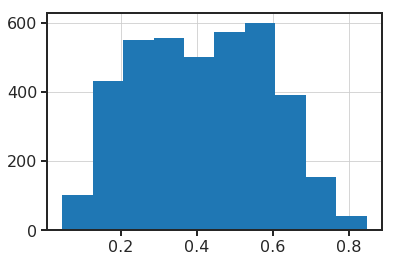

In [13]:
df4['ABA_normalized'].hist()

### Just the target 7 combination

In [14]:
perfect_sequence7 = 'GGGAATGGATCCACATCTACGAATTCGTT' + 'TTTGATCTGAAATATTCAGGTC' + 'TGCAGATCGGAAGAGCACACGT'
perfect_target7 = 'TTTGATCTGAAATATTCAGGTC'
#PERFECT_KD1 = df7_1[df7_1['sequence'] == perfect_sequence7].iloc[0]['kd']
#PERFECT_KD2 = df7_2[df7_2['sequence'] == perfect_sequence7].iloc[0]['kd']

In [24]:
df7.head()

,sequence,structure,mfe,ABA_normalized
0,GGGAATGGATCCACATCTACGAATTCGTTTTTGATCTGAAATATAG...,.(((.....)))......(((....(.(((((((((((.....(((...,-13.3,0.113309
1,GGGAATGGATCCACATCTACGAATTCGTTTTTGATCTGAAATATAT...,.(((.....)))......(((....(.(((((((((((...........,-12.9,0.217590
2,GGGAATGGATCCACATCTACGAATTCGTTTTTGATCTGAAATATTC...,.(((.....)))......(((....(.(((((((((((.......(...,-13.2,0.336245
3,GGGAATGGATCCACATCTACGAATTCGTTTGTGATCTGAAATATTC...,..(((((((((.(((...(((....))).)))))))).....))))...,-14.7,0.122793
4,GGGAATGGATCCACATCTACGAATTCGTTTTTGATCTGAAATATCT...,.(((.....)))......(((....(.(((((((((((...........,-13.1,0.137947


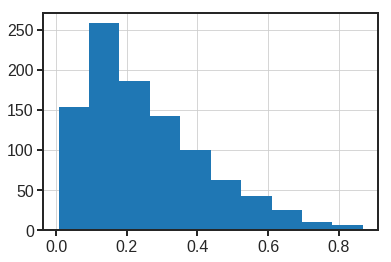

In [231]:
df7['ABA_normalized'].hist()

## Relative encoding

In [25]:
#TODO add y_max threshold


#This function recovers the sequence of changes (insertions/deletions/replacements)
#from the perfect sequence to the target sequence
def get_diff(perfect, x):
    output = []
    sm = edit_distance.SequenceMatcher(a=perfect, b=x)
    for row in sm.get_opcodes():
        if row[0] == "equal":
            continue
        elif row[0] == "insert":
            output.append((row[1], "insert", x[row[3]]))
        elif row[0] == "delete":
            output.append((row[1], "delete"))
        else:
            output.append((row[1], "replace", x[row[3]]))
    return output



# want to create a value mapping table of the changes
# the structure goes like this:
# [(index, i, A), (index, i, C), (index, i, G), (index, i  T),
#  (index, r, A), (index, r, C), (index, r, G), (index, r, T), (index, d)]
# index is the position on the rna, i is insertion, r is replacement, d is deletion,
# In the future we can try to have a way to combine these variables
def get_action(coord):
    if (coord % 9) == 0:
        return "INS A"
    if (coord % 9) == 1:
        return "INS C"
    if (coord % 9) == 2:
        return "INS G"
    if (coord % 9) == 3:
        return "INS T"
    if (coord % 9) == 4:
        return "REP A"
    if (coord % 9) == 5:
        return "REP C"
    if (coord % 9) == 6:
        return "REP G"
    if (coord % 9) == 7:
        return "REP T"
    if (coord % 9) == 8:
        return "DEL"
    

def get_position(coord):
    if len(coord) == 2:
        return coord[0]*9+8
    elif coord[1] == 'insert' and coord[2] == 'A':
        return coord[0]*9
    elif coord[1] == 'insert' and coord[2] == 'C':
        return coord[0]*9 + 1
    elif coord[1] == 'insert' and coord[2] == 'G':
        return coord[0]*9 + 2
    elif coord[1] == 'insert' and coord[2] == 'T':
        return coord[0]*9 + 3
    elif coord[1] == 'replace' and coord[2] == 'A':
        return coord[0]*9 + 4
    elif coord[1] == 'replace' and coord[2] == 'C':
        return coord[0]*9 + 5
    elif coord[1] == 'replace' and coord[2] == 'G':
        return coord[0]*9 + 6
    elif coord[1] == 'replace' and coord[2] == 'T':
        return coord[0]*9 + 7
    else:
        print ("INCORRECT COORDINATE")
        return -1

#Plots detailed results
def display(predicted, actual, title="Predicted vs Actual", ylabel="Fit (ABA)", xlabel="Measured (ABA)"):
    x,y = actual,predicted
    
    
    
    # definitions for the axes
    left, width = 0.02, 0.65
    bottom, height = 0.2, 0.65
    spacing = 0.02


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]

    # start with a rectangular Figure
    plt.figure(figsize=(8, 8))
    #plt.title("Predicted vs Expected ABA for Linear Regression Model")



    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    # the scatter plot:
    #ax_scatter.scatter(predicted, actual)
    ax_scatter.hexbin(x, y, edgecolors='none', gridsize=75,cmap='viridis',mincnt=1)
    ax_scatter.plot(np.unique(predicted), np.poly1d(np.polyfit(x,
                                                x, 1))(np.unique(y)), "k--")

    ax_scatter.set_xlabel(xlabel, fontsize=15)
    ax_scatter.set_ylabel(ylabel, fontsize=15)
    # now determine nice limits by hand:
    binwidth = 0.25
    lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
    ax_scatter.set_xlim((-0.1, 0.9))
    ax_scatter.set_ylim((-0.1, 0.9))

    bins = np.arange(-lim, lim + binwidth, binwidth)
    bins = 50
    ax_histx.hist(x, bins=bins,  color=(0.23, 0.06, 0.4))
    ax_histx.set_title(title,pad=15, fontsize=20)
    ax_histy.hist(y, bins=bins, orientation='horizontal',color=(0.23, 0.06, 0.4))

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())


    #plt.show()
# to help analyze results (older version)
def display1(predicted, actual, title="Predicted vs Actual"):
    #plt.scatter(predicted, actual)
    plt.figure(num=1,figsize=(5,5))
    plt.hexbin(predicted, actual, gridsize=(15,15),  cmap='Purples', edgecolors='none' )
    plt.plot(np.unique(predicted), np.poly1d(np.polyfit(actual,
                                                actual, 1))(np.unique(predicted)))
    #plt.show()
    plt.ylabel("predicted ABA")
    plt.xlabel("actual ABA")
    plt.title(title)
    plt.show()
    #now we build the table that we will use for regressions

def shuffle(X, y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y
    
    
#think of data_matrix as input and output variable as output
#seq_aba_pairs = big_table.groupby('sequence')['ABA'].apply(float).to_dict()
def create_matrix(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA_normalized'].apply(float).to_dict()
    
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        #seq = sequence[29: -32]
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq[29: -22])
            if len(coords) > 5:
                pass
            else:
                row = [0 for i in range(9*len(perfect_sequence))]
                for coord in coords:
                    row[get_position(coord)] = 1
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    #X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    #X = X[indices]
    #y = y[indices]
    
    return X, y

In [860]:
df4_encoding, aba4 = create_matrix(df4, perfect_sequence = perfect_target4)

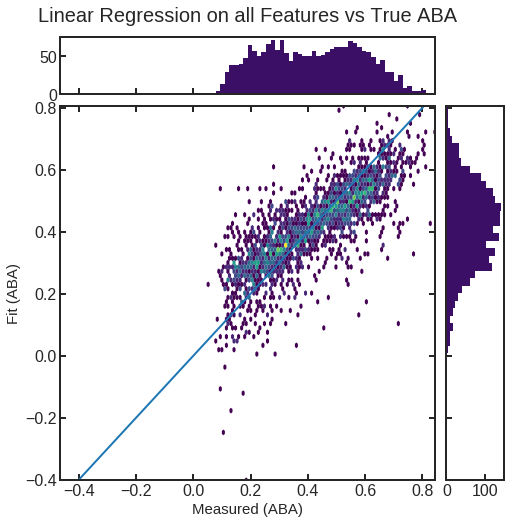

('test correlation is', 0.7936160591546401)


In [732]:
#just to show that we aren't really over-fitting
X,y = df4_encoding, aba4

X, y = shuffle(X,y)
#cutoff = 1800

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
ENC_CORR4 = corr

In [861]:
df7_encoding, aba7 = create_matrix(df7, perfect_sequence = perfect_target7)

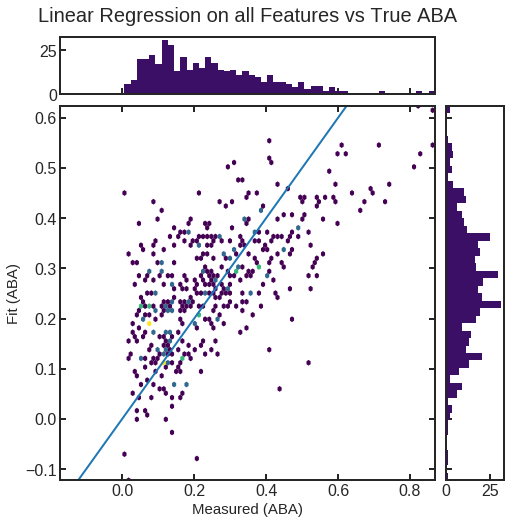

('test correlation is', 0.6483758774560637)


In [734]:
#just to show that we aren't really over-fitting
X,y = df7_encoding, aba7

X, y = shuffle(X,y)
cutoff = 500

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
ENC_CORR7 = corr

In [26]:
df4_encoding, aba4 = create_matrix(df4, perfect_sequence = perfect_target4)
df7_encoding, aba7 = create_matrix(df7, perfect_sequence = perfect_target7)

#want target 4 and target 7 to be around equal weights (same number)
combined_encoding = np.concatenate((df4_encoding[:], df7_encoding), axis=0)

combined_aba = np.concatenate((aba4[:], aba7), axis=0)
combined_aba.shape

(4862,)

('test correlation is', 0.6393008450402186)
-5698.392983234169


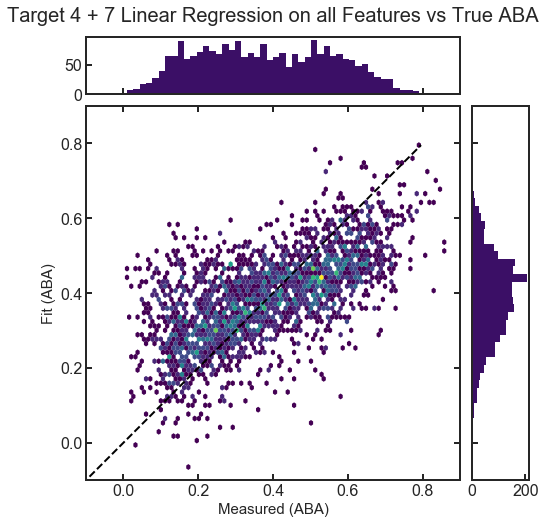

In [27]:
#just to show that we aren't really over-fitting
X,y = combined_encoding, combined_aba

X, y = shuffle(X,y)
cutoff = 2403

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Target 4 + 7 Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
ENC_CORR = corr

regr = OLS(y, add_constant(X)).fit()
model1 = regr.aic
print(regr.aic)

## Adding Free Energy

In [864]:
def create_matrix2(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA_normalized'].apply(float).to_dict()
    
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        #seq = sequence[29: -32]
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq[29: -22])
            if len(coords) > 5:
                pass
            else:
                row = [0 for i in range(9*len(perfect_sequence))]
                for coord in coords:
                    row[get_position(coord)] = 1
                row.append(big_table[big_table['sequence'] == seq].iloc[0]['mfe'])
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    #X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    return X, y

In [865]:
df4_encoding, aba4 = create_matrix2(df4, perfect_sequence = perfect_target4)

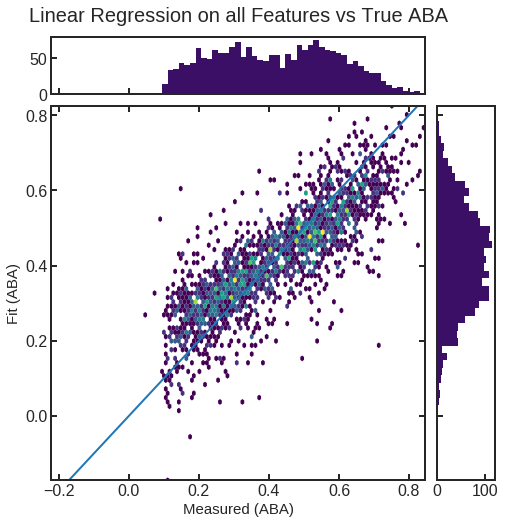

('test correlation is', 0.825502007481555)


In [741]:
#just to show that we aren't really over-fitting
X,y = df4_encoding, aba4

X, y = shuffle(X,y)
cutoff = 1800

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
ENERGY_ENC_CORR4 = corr

In [866]:
df7_encoding, aba7 = create_matrix2(df7, perfect_sequence = perfect_target7)

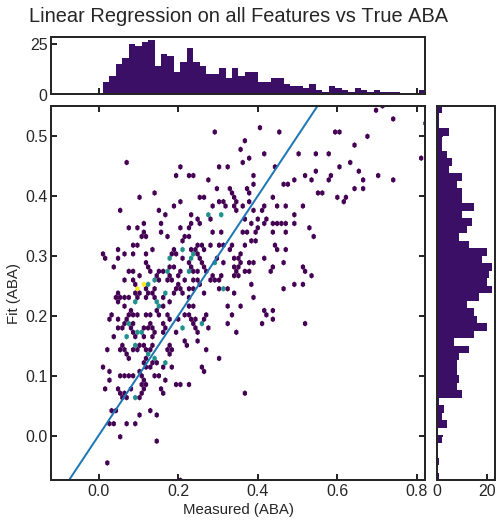

('test correlation is', 0.6586379946285124)


In [743]:
#just to show that we aren't really over-fitting
X,y = df7_encoding, aba7

X, y = shuffle(X,y)
cutoff = 500

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
ENERGY_ENC_CORR7 = corr

In [867]:
df4_encoding, aba4 = shuffle(df4_encoding,aba4)

#want target 4 and target 7 to be around equal weights (same number)
combined_encoding = np.concatenate((df4_encoding[:], df7_encoding), axis=0)

combined_aba = np.concatenate((aba4[:], aba7), axis=0)

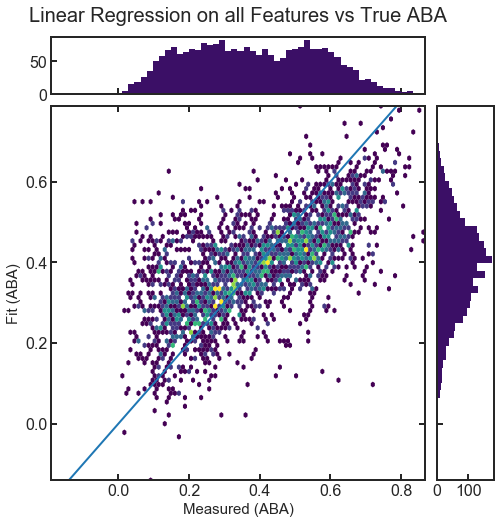

('test correlation is', 0.6625381222825395)
-5732.942200167634


In [868]:
#just to show that we aren't really over-fitting
X,y = combined_encoding, combined_aba

X, y = shuffle(X,y)
cutoff = 2403

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
ENERGY_ENC_CORR = corr

regr = OLS(y, add_constant(X)).fit()
model2 = regr.aic
print(regr.aic)

# Looking at free energy

In [597]:
ENERGY_CORR7 = pearsonr(df7['mfe'],df7['ABA_normalized'])[0]
print ENERGY_CORR7

0.31223947661514245


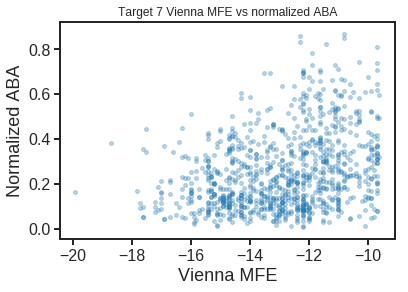

In [451]:
plt.xlabel("Vienna MFE")
plt.ylabel("Normalized ABA")
plt.title("Target 7 Vienna MFE vs normalized ABA")
plt.scatter(df7['mfe'],df7['ABA_normalized'], alpha=0.3, s=15, c=[0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.3])
plt.show()

In [598]:
ENERGY_CORR4 = pearsonr(df4['mfe'],df4['ABA_normalized'])[0]
print ENERGY_CORR4

0.27643639592985647


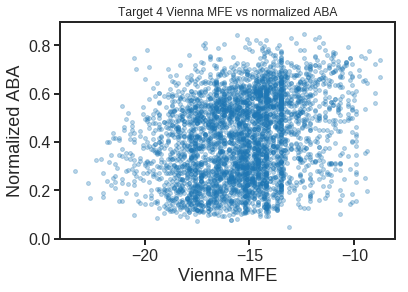

In [599]:
plt.xlabel("Vienna MFE")
plt.ylabel("Normalized ABA")
plt.title("Target 4 Vienna MFE vs normalized ABA")
plt.scatter(df4['mfe'],df4['ABA_normalized'], alpha=0.3, s=15, c=[0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.3])
plt.show()

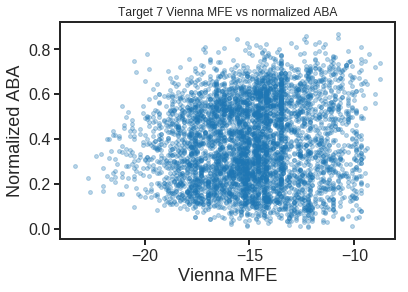

In [600]:
plt.xlabel("Vienna MFE")
plt.ylabel("Normalized ABA")
plt.title("Target 7 Vienna MFE vs normalized ABA")
plt.scatter(list(df7['mfe'])+list(df4['mfe']),
            list(df7['ABA_normalized'])+list(df4['ABA_normalized']),
            alpha=0.3, s=15, c=[0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.3])
plt.show()

In [840]:
ENERGY_CORR= pearsonr(list(df7['mfe'])+list(df4['mfe']),
            list(df7['ABA_normalized'])+list(df4['ABA_normalized']))[0]
print ENERGY_CORR

0.09098886547783624


# Looking at base pairings

In [30]:
#free energy bonds
def dots_to_features(string):
    arr = []
    for char in string:
        if char == '.':
            arr.append(0)
        elif char == ')' or char == '(':
            arr.append(1)
    return arr

def generate_structure_matrix(table):
    X, y = [],[]
    for i, row in table.iterrows():
        #print(len(row['sequence']))
        ss = row['structure']
        X.append(dots_to_features(ss)[29:29+22])
        y.append(row['ABA_normalized'])
    return np.array(X), np.array(y)

## Target 4 structure vs ABA

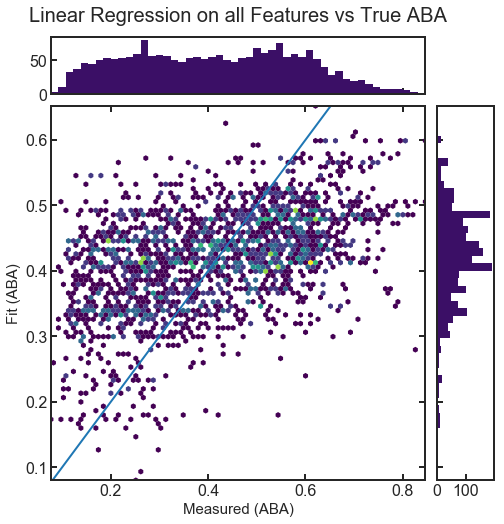

('test correlation is', 0.46642881849995016)


In [870]:
# the start of this function is same as before
X,y = generate_structure_matrix(df4)

X, y = shuffle(X,y)
cutoff = 1800

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
STRUC_CORR4 = corr

## Target 7 structure vs ABA

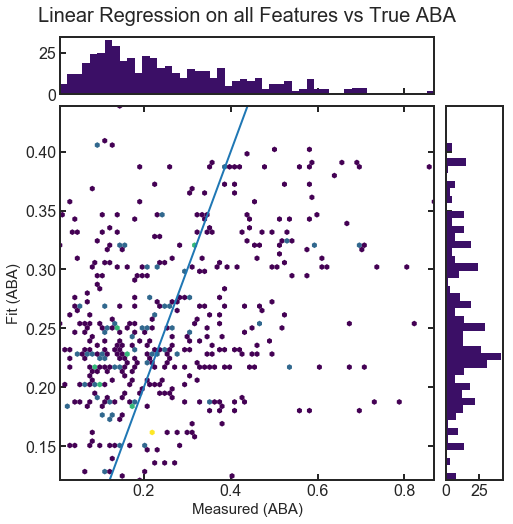

('test correlation is', 0.3455291027142426)


In [871]:
# the start of this function is same as before
X,y = generate_structure_matrix(df7)

X, y = shuffle(X,y)
cutoff = 500

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
STRUC_CORR7 = corr

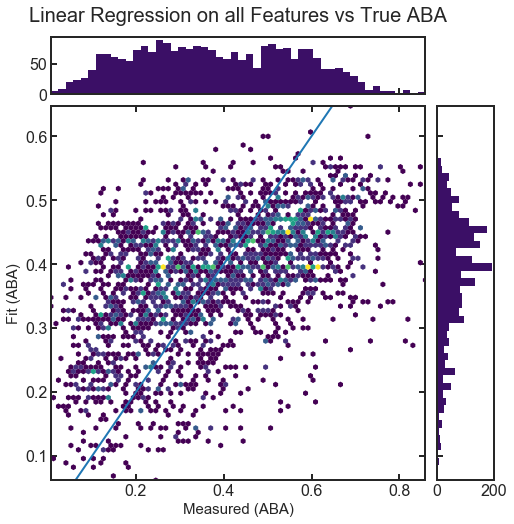

('test correlation is', 0.5106892643108387)
-4231.707896567823


In [872]:
# the start of this function is same as before
X,y = generate_structure_matrix(pd.concat([df4,df7], axis=0))

X, y = shuffle(X,y)
cutoff = 2403

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
STRUC_CORR = corr

regr = OLS(y, add_constant(X)).fit()
model3 = regr.aic
print(regr.aic)

## Combining structure(base pair + MFE)

In [873]:
def generate_bp_mfe_matrix(table):
    X, y = [],[]
    for i, row in table.iterrows():
        #print(len(row['sequence']))
        output = []
        ss = row['structure']
        output.append(row['mfe'])
        output.extend(dots_to_features(ss)[26:26+22])
        X.append(output)
        y.append(row['ABA_normalized'])
    return np.array(X), np.array(y)

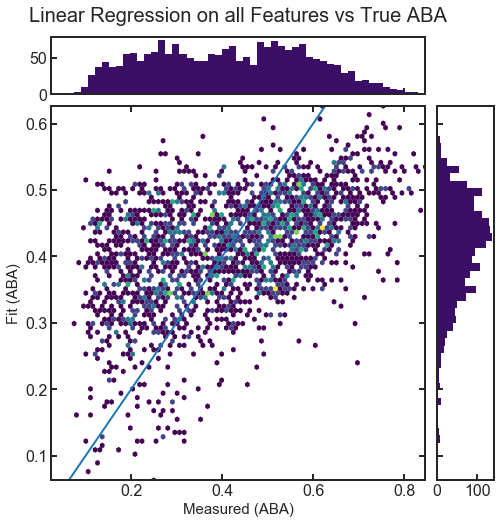

('test correlation is', 0.4886647356259858)


In [874]:
# the start of this function is same as before
X,y = generate_bp_mfe_matrix(df4)

X, y = shuffle(X,y)
cutoff = 1800

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
STRUC_ENERGY_CORR4 = corr

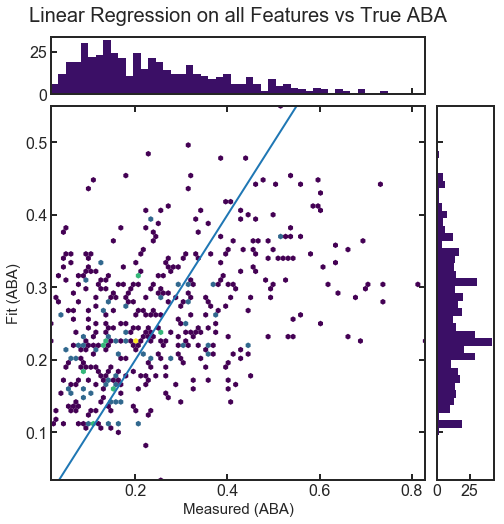

('test correlation is', 0.4396479287259702)


In [875]:
# the start of this function is same as before
X,y = generate_bp_mfe_matrix(df7)

X, y = shuffle(X,y)
cutoff = 500

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
STRUC_ENERGY_CORR7 = corr

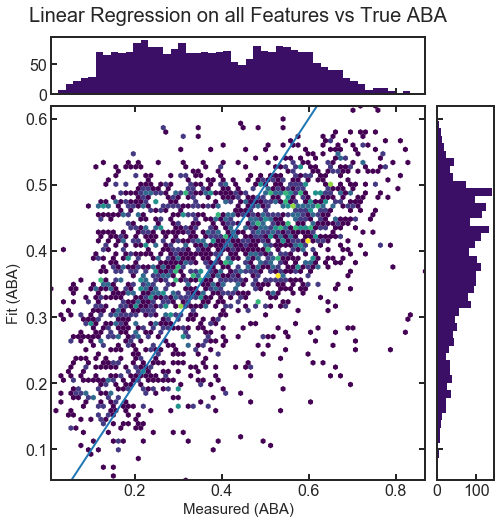

('test correlation is', 0.5184501158474044)
-4446.027026806383


In [876]:
# the start of this function is same as before
X,y = generate_bp_mfe_matrix(pd.concat([df4,df7], axis=0))

X, y = shuffle(X,y)
cutoff = 2403

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
STRUC_ENERGY_CORR = corr

regr = OLS(y, add_constant(X)).fit()
model4 = regr.aic
print(regr.aic)

## Combining structure(base pair) and relative encoding

In [877]:
def create_matrix_with_bp(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA_normalized'].apply(float).to_dict()
    
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        #seq = sequence[29: -32]
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq[29: -22])
            if len(coords) > 5:
                pass
            else:
                row = [0 for i in range(9*len(perfect_sequence))]
                for coord in coords:
                    row[get_position(coord)] = 1
                bindings = big_table[big_table['sequence'] == seq].iloc[0]['structure']
                row.extend((dots_to_features(bindings))[29:29+22])
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
                
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    #X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    #X = X[indices]
    #y = y[indices]
    
    return X, y

In [878]:
X,y = create_matrix_with_bp(df4, perfect_sequence = perfect_target4)

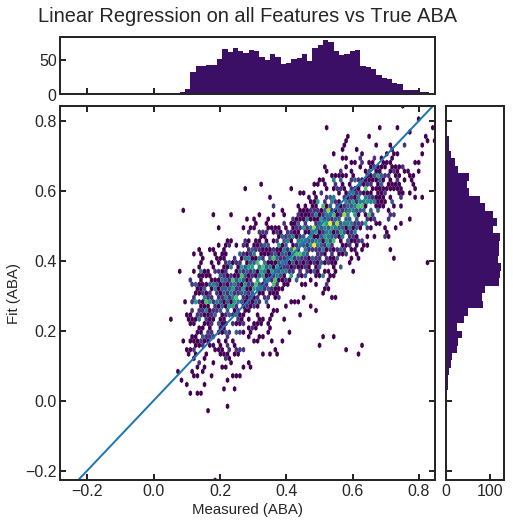

('test correlation is', 0.8142089134058148)


In [763]:
#just to show that we aren't really over-fitting
#X,y = combined_encoding, combined_aba

X, y = shuffle(X,y)
cutoff = 1800

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
ENC_STRUC_CORR4 = corr

In [879]:
X,y = create_matrix_with_bp(df7, perfect_sequence = perfect_target7)

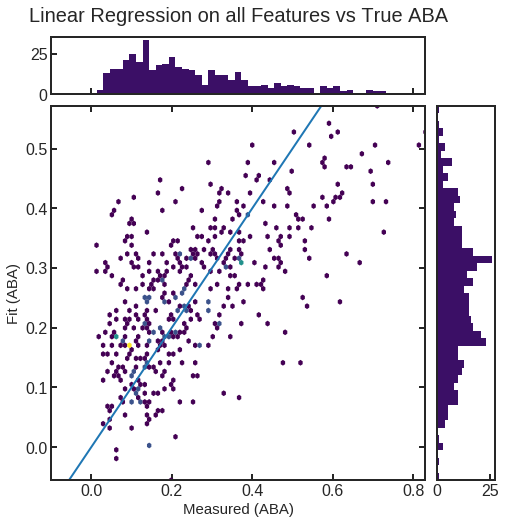

('test correlation is', 0.6450042554948362)


In [765]:
#just to show that we aren't really over-fitting
#X,y = combined_encoding, combined_aba

X, y = shuffle(X,y)
cutoff = 500

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
ENC_STRUC_CORR7 = corr

In [880]:
df4_encoding, aba4 = create_matrix_with_bp(df4, perfect_sequence = perfect_target4)
df4_encoding, aba4 = shuffle(df4_encoding,aba4)
df7_encoding, aba7 = create_matrix_with_bp(df7, perfect_sequence = perfect_target7)
df7_encoding, aba7 = shuffle(df7_encoding,aba7)

#want target 4 and target 7 to be around equal weights (same number)
combined_encoding = np.concatenate((df4_encoding[:], df7_encoding), axis=0)

combined_aba = np.concatenate((aba4[:], aba7), axis=0)

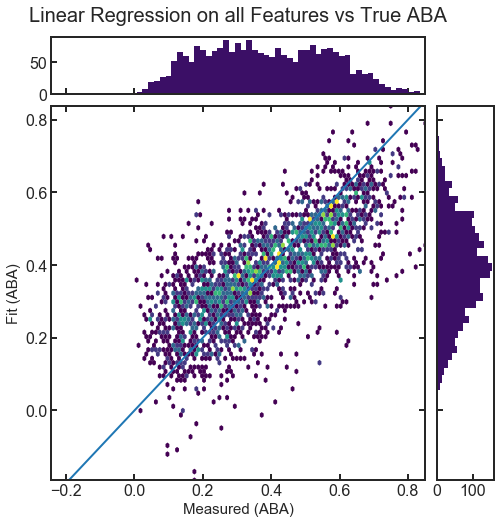

('test correlation is', 0.7500285892435407)
-6972.645007446836


In [881]:
#just to show that we aren't really over-fitting
X,y = combined_encoding, combined_aba

X, y = shuffle(X,y)
cutoff = 2403

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
ENC_STRUC_CORR = corr

regr = OLS(y, add_constant(X)).fit()
model5 = regr.aic
print(regr.aic)

## Combining structure and relative encoding

In [61]:
def create_matrix_with_structure(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA_normalized'].apply(float).to_dict()
    
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        #seq = sequence[29: -32]
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq[29: -22])
            if len(coords) > 5:
                pass
            else:
                row = [0 for i in range(9*len(perfect_sequence))]
                for coord in coords:
                    row[get_position(coord)] = 1
                row.append(big_table[big_table['sequence'] == seq].iloc[0]['mfe'])
                bindings = big_table[big_table['sequence'] == seq].iloc[0]['structure']
                row.extend((dots_to_features(bindings))[29:29+22])
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
                
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    #X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    #X = X[indices]
    #y = y[indices]
    
    return X, y

In [62]:
X,y = create_matrix_with_structure(df4, perfect_sequence = perfect_target4)

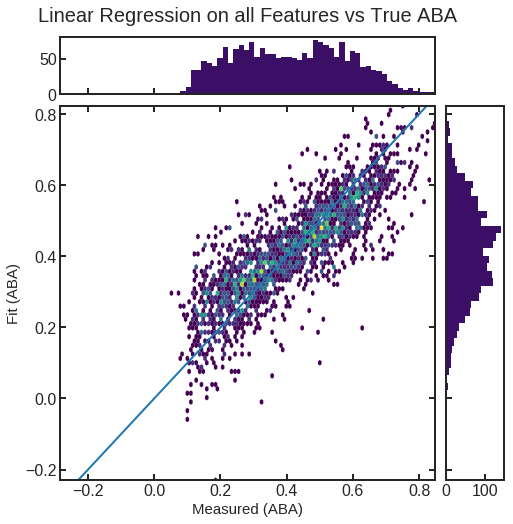

('test correlation is', 0.8297855545241581)
-7379.426810707668


In [770]:
#just to show that we aren't really over-fitting
#X,y = combined_encoding, combined_aba

X, y = shuffle(X,y)
cutoff = 1800

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
ENC_STRUC_ENERGY_CORR4 = corr

regr = OLS(y, add_constant(X)).fit()
print(regr.aic)

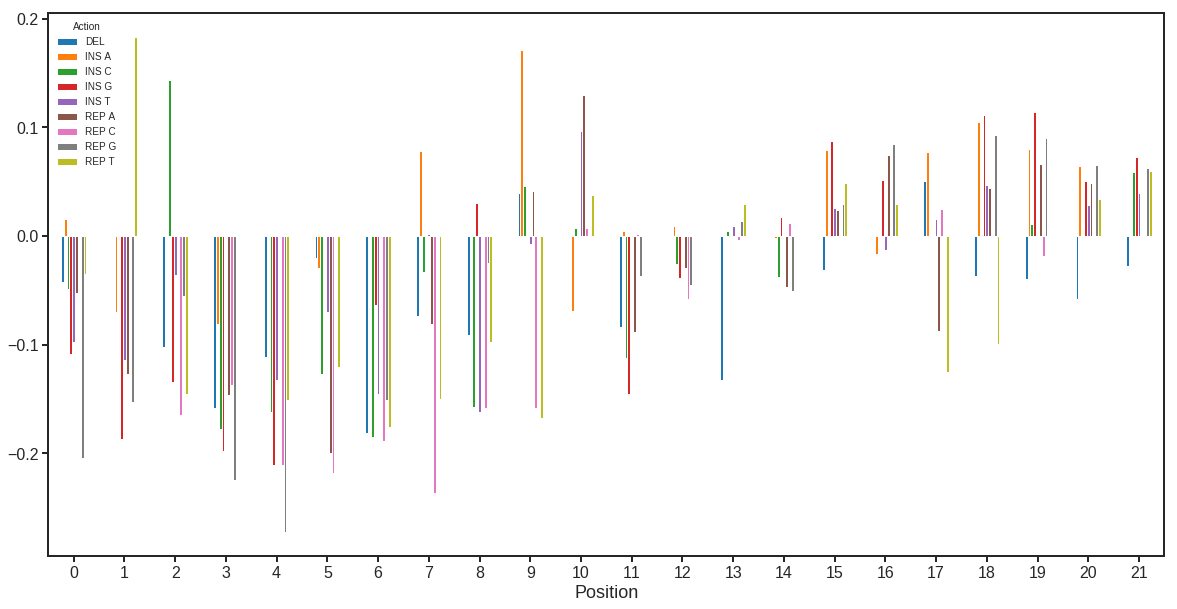

In [666]:
hist_plot(reg.coef_[0:22*9])
#CCATAGAGAGGTTATCCGCTCA

<BarContainer object of 22 artists>

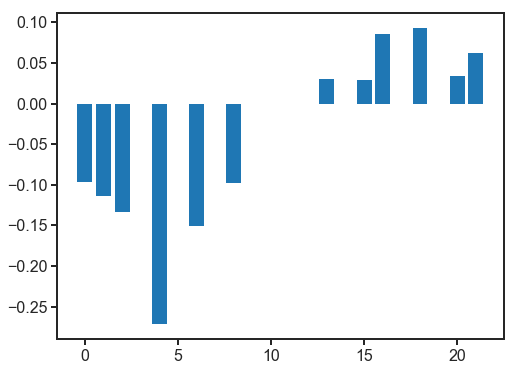

In [938]:
#for i in range(198):
    #print feature_label(i), reg.coef_[0:22*9][i]
#CCATAGAGAGGTTATCCGCTCA
wob = [-0.097,-0.114,-0.134,0,-0.272,0,-0.151,0,-0.098,0,0,0,0,0.030,0,0.029,0.085,0,0.093,0,0.034,0.062]

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(range(22),wob)

In [771]:
X,y = create_matrix_with_structure(df7, perfect_sequence = perfect_target7)

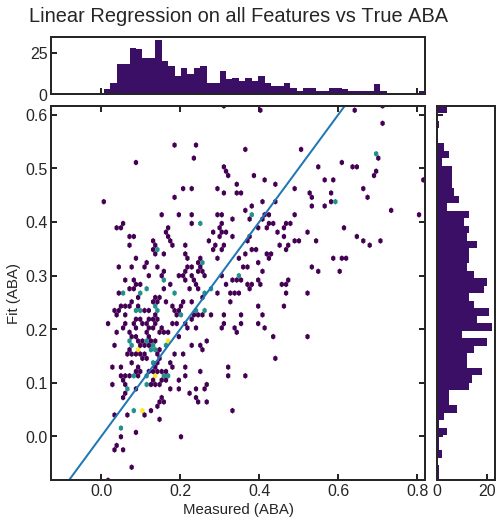

('test correlation is', 0.6274328064093658)
-1376.1510577904196


In [772]:
#just to show that we aren't really over-fitting
#X,y = combined_encoding, combined_aba

X, y = shuffle(X,y)
cutoff = 500

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
ENC_STRUC_ENERGY_CORR7 = corr

regr = OLS(y, add_constant(X)).fit()
print(regr.aic)

In [66]:
df4_encoding, aba4 = create_matrix_with_structure(df4, perfect_sequence = perfect_target4)
df4_encoding, aba4 = shuffle(df4_encoding,aba4)
df7_encoding, aba7 = create_matrix_with_structure(df7, perfect_sequence = perfect_target7)
df7_encoding, aba7 = shuffle(df7_encoding,aba7)

#want target 4 and target 7 to be around equal weights (same number)
combined_encoding = np.concatenate((df4_encoding[:], df7_encoding), axis=0)

combined_aba = np.concatenate((aba4[:], aba7), axis=0)

('test correlation is', 0.7594855617473301)
-7262.095314928423


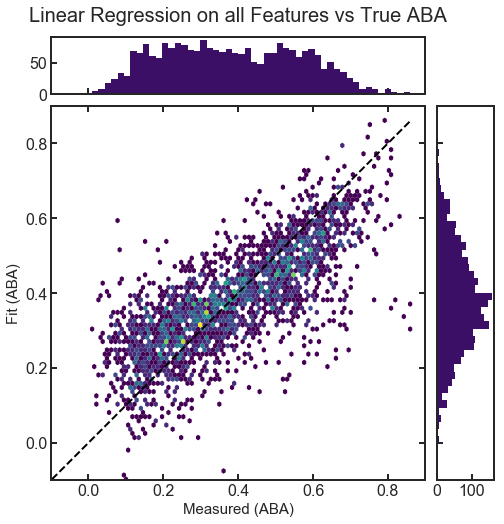

In [70]:
#just to show that we aren't really over-fitting
X,y = combined_encoding, combined_aba

X, y = shuffle(X,y)
cutoff = 2400

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)
ENC_STRUC_ENERGY_CORR = corr
regr = OLS(y, add_constant(X)).fit()
model6 = regr.aic
print(regr.aic)

plt.tight_layout()
#plt.savefig('/mnt/agate/hdd3/home/jami/notebooks/manuscript_fig/fig4_measured_fit_correlation.eps', format='eps', transparent=True, bbox_inches='tight')
#plt.show()

('test correlation is', 0.7961240366785743)


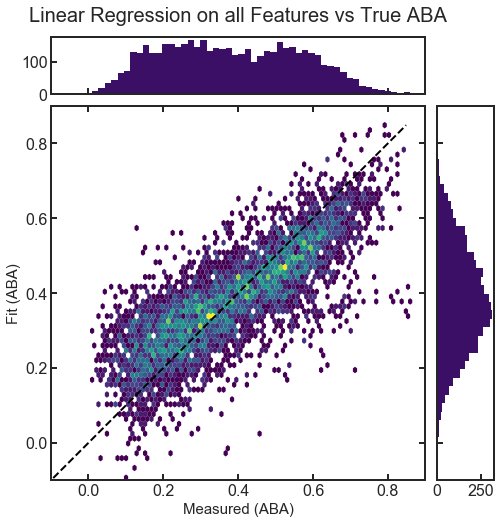

In [72]:
#just to show that we aren't really over-fitting
#X,y = combined_encoding, combined_aba

#X, y = shuffle(X,y)
cutoff = 2403

X_train = X[:]
y_train = y[:]

X_test = X[:]
y_test = y[:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)

#plt.tight_layout()
#plt.savefig('/mnt/agate/hdd3/home/jami/notebooks/manuscript_fig/fig4_measured_fit_correlation.eps', format='eps', transparent=True)
#plt.show()

In [49]:
fs = SelectKBest(score_func=mutual_info_regression, k='all')
# learn relationship from training data
fs.fit(X_train, y_train)
# transform train input data
X_train_fs = fs.transform(X_train)
# transform test input data
X_test_fs = fs.transform(X_test)

# what are scores for the features
#for i in range(len(fs.scores_)):
    #print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
#plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
#plt.show()

In [50]:
scores = fs.scores_
non_pool_fs = scores[:10*len(perfect_sequence4)+1]

Text(0.5,0,'Features')

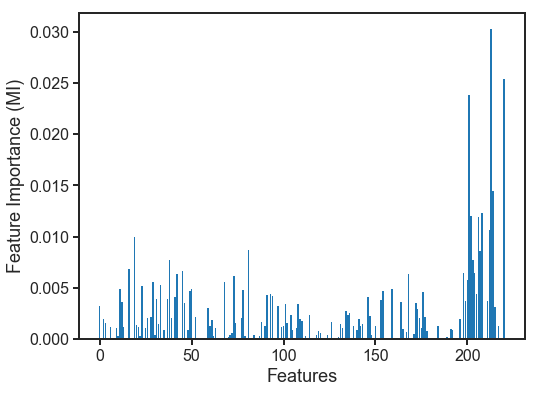

In [51]:
fig, ax = plt.subplots(figsize=(8,6))
ax.bar([i for i in range(len(non_pool_fs))], non_pool_fs)
#ax.set_title("Mutual Info of Listed Various Features")
ax.set_ylabel("Feature Importance (MI)")
ax.set_xlabel("Features")

(197.3, 221)

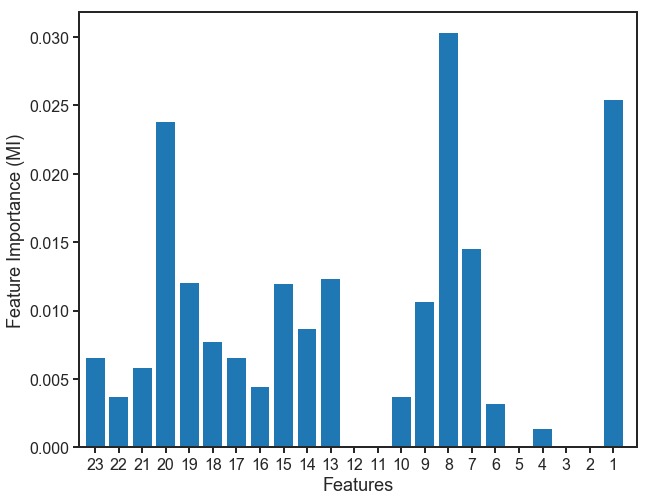

In [52]:
fig, ax = plt.subplots(figsize=(10,8))
ax.bar([i for i in range(len(non_pool_fs))], non_pool_fs)
#ax.set_title("Mutual Info of Listed Various Features")
ax.set_ylabel("Feature Importance (MI)")
ax.set_xlabel("Features")
ax.set_xticks(range(221))
ax.set_xticklabels(range(221, 0, -1))
ax.set_xlim(197.3,221)

In [53]:
def hist_plot(arr):
    df = pd.DataFrame({"Position": [int(elt/9) for elt in range(len(arr))],
                        "Action": [get_action(elt) for elt in range(len(arr))],
                            "Val": arr})
    df.pivot(index = "Position", columns = "Action", values = "Val").plot.bar(edgecolor = "white", figsize=(20,10))
    plt.xticks(rotation = 0)
    plt.show()

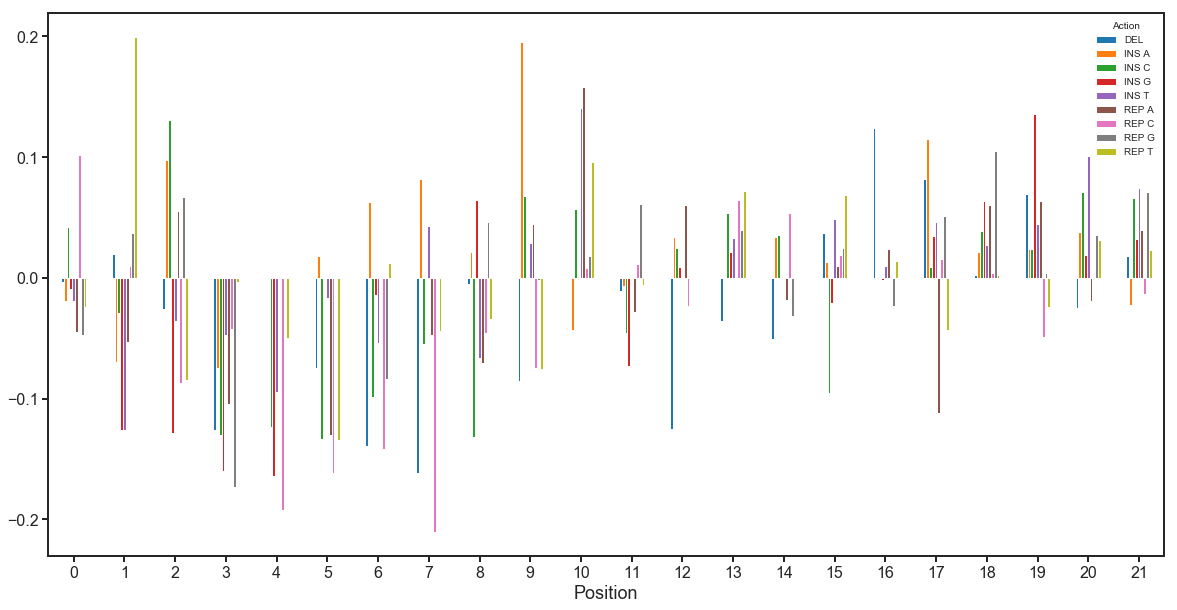

In [54]:
hist_plot(reg.coef_[0:22*9])

In [55]:
print len(reg.coef_[199:])

22


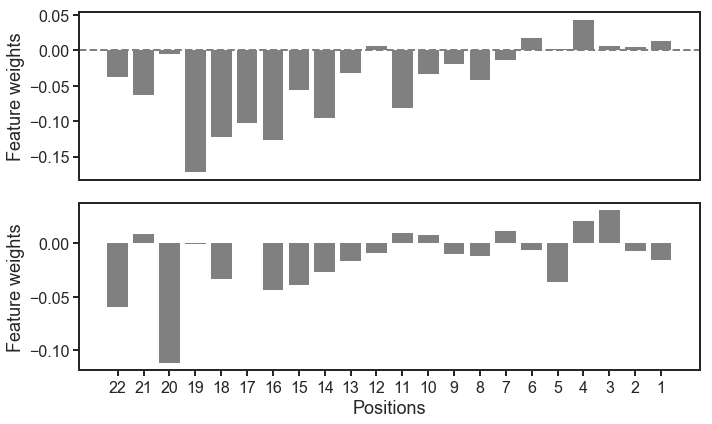

In [75]:
fig, (ax,ax1) = plt.subplots(2,1,figsize=(10,6))
ids = np.arange(len(reg.coef_[0:22*9]))//9
np.bincount(ids,reg.coef_[0:22*9])/np.bincount(ids)
ax.bar(range(22),np.bincount(ids,reg.coef_[0:22*9])/np.bincount(ids),color='grey')
ax.set_ylabel('Feature weights')
ax.get_xaxis().set_visible(False)
ax.axhline(0, linestyle='--', color='gray')

ax1.bar(range(22),reg.coef_[199:],color='grey')
ax1.set_ylabel('Feature weights')
ax1.set_xlabel('Positions')
ax1.set_xticks(range(22))
ax1.set_xticklabels(range(22, 0, -1))
plt.tight_layout()
#plt.savefig('/mnt/agate/hdd3/home/jami/notebooks/manuscript_fig/fig4_combined_feature_weights_new.eps', format='eps', transparent=True)

In [909]:
print len(reg.coef_)
print len(reg.coef_[199:])

221
22


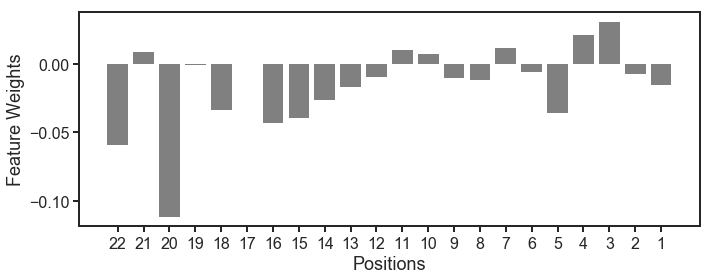

In [74]:
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(range(22),reg.coef_[199:],color='grey')
ax.set_ylabel('Feature Weights')
ax.set_xlabel('Positions')
ax.set_xticks(range(22))
ax.set_xticklabels(range(22, 0, -1))
plt.tight_layout()
#plt.savefig('/mnt/agate/hdd3/home/jami/notebooks/manuscript_fig/fig4_bp_feature_weights.eps', format='eps', transparent=True)

In [659]:
# get feature from column given this SPECIFIC DATASET Target4 (need to update for other targets)
def feature_label(col, perfect_sequence=target4):
    if col < len(perfect_sequence)*9:
        return "pos " + str(int(col/9) + 1) + " " + get_action(col)
    elif col == len(perfect_sequence)*9:
        return "free energy"
    elif col < len(perfect_sequence)*9 + 1 + len(perfect_sequence):
        return "paired/free base " + str(col- len(perfect_sequence)*9)
    else:
        return "pool feature" + str(col- len(perfect_sequence)*10)

In [530]:
#for i in range(221):
#    print(i, feature_label(i))

In [47]:
top_10 = non_pool_fs.argsort()[:][::-1]
for i in top_10:
    print(feature_label(i), " ", non_pool_fs[i] )

NameError: name 'non_pool_fs' is not defined

Text(0.5,1,'Combined 4+7 Venn Diagram')

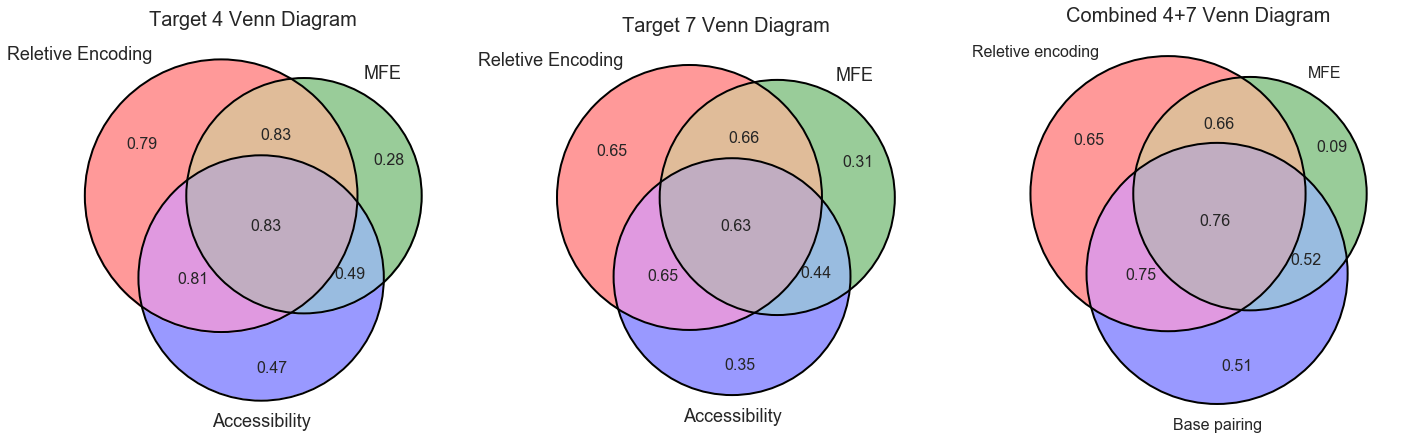

In [886]:
from matplotlib_venn import venn3, venn3_circles
fig, (ax,ax1,ax2) = plt.subplots(1,3,figsize=(24,8))

ENC_CORR4, ENERGY_CORR4, ENERGY_ENC_CORR4, STRUC_CORR4= (np.round(ENC_CORR4,2),np.round(ENERGY_CORR4,2),
                                                     np.round(ENERGY_ENC_CORR4,2), np.round(STRUC_CORR4,2))
ENC_STRUC_CORR4, STRUC_ENERGY_CORR4, ENC_STRUC_ENERGY_CORR4 = (np.round(ENC_STRUC_CORR4,2),np.round(STRUC_ENERGY_CORR4,2),
                                                     np.round(ENC_STRUC_ENERGY_CORR4,2))

v = venn3(ax=ax, subsets = (ENC_CORR4, ENERGY_CORR4, ENERGY_ENC_CORR4, STRUC_CORR4, ENC_STRUC_CORR4,
                 STRUC_ENERGY_CORR4, ENC_STRUC_ENERGY_CORR4), set_labels = ('Reletive Encoding', 'MFE', 'Accessibility'))

c = venn3_circles(ax=ax, subsets = (ENC_CORR4, ENERGY_CORR4, ENERGY_ENC_CORR4, STRUC_CORR,ENC_STRUC_CORR4,
                 STRUC_ENERGY_CORR4, ENC_STRUC_ENERGY_CORR4))

for text in v.set_labels:
    text.set_fontsize(18)
for text in v.subset_labels:
    text.set_fontsize(16)
    
ENC_CORR7, ENERGY_CORR7, ENERGY_ENC_CORR7, STRUC_CORR7= (np.round(ENC_CORR7,2),np.round(ENERGY_CORR7,2),
                                                     np.round(ENERGY_ENC_CORR,2), np.round(STRUC_CORR7,2))
ENC_STRUC_CORR7, STRUC_ENERGY_CORR7, ENC_STRUC_ENERGY_CORR7 = (np.round(ENC_STRUC_CORR7,2),np.round(STRUC_ENERGY_CORR7,2),
                                                     np.round(ENC_STRUC_ENERGY_CORR7,2))

v = venn3(ax=ax1, subsets = (ENC_CORR7, ENERGY_CORR7, ENERGY_ENC_CORR7, STRUC_CORR7,ENC_STRUC_CORR7,
                 STRUC_ENERGY_CORR7, ENC_STRUC_ENERGY_CORR7), set_labels = ('Reletive Encoding', 'MFE', 'Accessibility'))

c = venn3_circles(ax=ax1, subsets = (ENC_CORR7, ENERGY_CORR7, ENERGY_ENC_CORR7, STRUC_CORR7, ENC_STRUC_CORR7,
                 STRUC_ENERGY_CORR7, ENC_STRUC_ENERGY_CORR7))

for text in v.set_labels:
    text.set_fontsize(18)
for text in v.subset_labels:
    text.set_fontsize(16)


ENC_CORR, ENERGY_CORR, ENERGY_ENC_CORR, STRUC_CORR= (np.round(ENC_CORR,2),np.round(ENERGY_CORR,2),
                                                     np.round(ENERGY_ENC_CORR,2), np.round(STRUC_CORR,2))
ENC_STRUC_CORR, STRUC_ENERGY_CORR, ENC_STRUC_ENERGY_CORR = (np.round(ENC_STRUC_CORR,2),np.round(STRUC_ENERGY_CORR,2),
                                                     np.round(ENC_STRUC_ENERGY_CORR,2))

v = venn3(ax=ax2, subsets = (ENC_CORR, ENERGY_CORR, ENERGY_ENC_CORR, STRUC_CORR, ENC_STRUC_CORR ,
                 STRUC_ENERGY_CORR, ENC_STRUC_ENERGY_CORR), set_labels = ('Reletive encoding', 'MFE', 'Base pairing'))

c = venn3_circles(ax=ax2, subsets = (ENC_CORR, ENERGY_CORR, ENERGY_ENC_CORR, STRUC_CORR,ENC_STRUC_CORR ,
                 STRUC_ENERGY_CORR, ENC_STRUC_ENERGY_CORR))

for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(16)

    
ax.set_title("Target 4 Venn Diagram", fontsize=20)
ax1.set_title("Target 7 Venn Diagram", fontsize=20)    
ax2.set_title("Combined 4+7 Venn Diagram", fontsize=20)


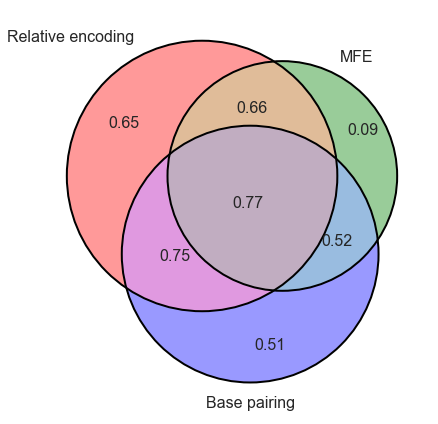

In [951]:
fig, ax = plt.subplots(figsize=(6,6))

ENC_CORR, ENERGY_CORR, ENERGY_ENC_CORR, STRUC_CORR= (np.round(ENC_CORR,2),np.round(ENERGY_CORR,2),
                                                     np.round(ENERGY_ENC_CORR,2), np.round(STRUC_CORR,2))
ENC_STRUC_CORR, STRUC_ENERGY_CORR, ENC_STRUC_ENERGY_CORR = (np.round(ENC_STRUC_CORR,2),np.round(STRUC_ENERGY_CORR,2),
                                                     np.round(ENC_STRUC_ENERGY_CORR,2))

v = venn3(ax=ax, subsets = (ENC_CORR, ENERGY_CORR, ENERGY_ENC_CORR, STRUC_CORR, ENC_STRUC_CORR ,
                 STRUC_ENERGY_CORR, ENC_STRUC_ENERGY_CORR), set_labels = ('Relative encoding', 'MFE', 'Base pairing'))

c = venn3_circles(ax=ax, subsets = (ENC_CORR, ENERGY_CORR, ENERGY_ENC_CORR, STRUC_CORR,ENC_STRUC_CORR ,
                 STRUC_ENERGY_CORR, ENC_STRUC_ENERGY_CORR))

for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(16)
plt.tight_layout()
plt.savefig('/mnt/agate/hdd3/home/jami/notebooks/manuscript_fig/fig4_venn_diagram.svg', format='svg', transparent=True)

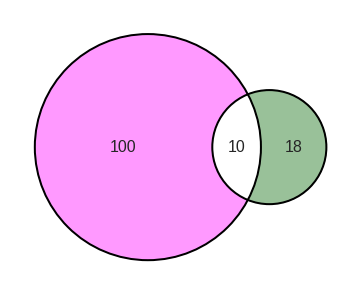

In [40]:
from matplotlib_venn import venn2, venn2_circles

fig, ax = plt.subplots(figsize=(6,6))
v = venn2(ax=ax, subsets = (100, 18, 10), set_labels = ('', ''))

c = venn2_circles(ax=ax, subsets = (100, 18, 10))

for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(16)
v.get_patch_by_id('10').set_color('magenta')
v.get_patch_by_id('11').set_color('white')
v.get_patch_by_id('01').set_color('darkgreen')
    
plt.savefig('/mnt/agate/hdd3/home/jami/notebooks/model_cas13d/fig_for_joy_1.svg', format='svg', transparent=True)

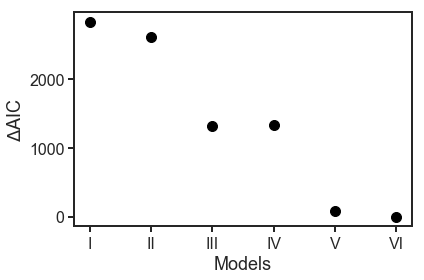

In [967]:
fig, ax = plt.subplots(figsize=(6,4))

xticks = ['I', 'II', 'III', 'IV', 'V', 'VI']
ax.plot(1, model3-model6, 'o', c='k', markersize=10)
ax.plot(2, model4-model6, 'o', c='k', markersize=10)
ax.plot(3, model1-model6, 'o', c='k', markersize=10)
ax.plot(4, model2-model6, 'o', c='k', markersize=10)
ax.plot(5, model5-model6, 'o', c='k', markersize=10)
ax.plot(6, model6-model6, 'o', c='k', markersize=10)
ax.set_xticks(range(1,7))
ax.set_xticklabels(xticks)
ax.set_ylabel("$\Delta$AIC")
ax.set_xlabel('Models')
plt.tight_layout()
plt.savefig('/mnt/agate/hdd3/home/jami/notebooks/manuscript_fig/fig4_aic.eps', format='eps', transparent=True)

In [782]:
#for the relative encoding the aic is 
regr = OLS(add_constant(X), y).fit()
print(regr.aic)

33133.486010879504


In [729]:
#for the relative encoding the aic combined with structure
regr = OLS(combined_encoding, add_constant(combined_aba)).fit()
print(regr.aic)

25501.92802612036


In [990]:
def create_matrix_with_structure_for_prediction(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA_normalized'].apply(float).to_dict()
    
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 6:
            coords = get_diff(perfect_sequence, seq[29: -22])
            if len(coords) > 5:
                pass
            else:
                row = [0 for i in range(9*len(perfect_sequence))]
                for coord in coords:
                    row[get_position(coord)] = 1
                row.append(big_table[big_table['sequence'] == seq].iloc[0]['mfe'])
                bindings = big_table[big_table['sequence'] == seq].iloc[0]['structure']
                row.extend((dots_to_features(bindings))[29:29+22])
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
                
    X = np.array(pruned_combined_data_matrix)
    #scaling for later
    #X = preprocessing.scale(X)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    #X = X[indices]
    #y = y[indices]
    
    return X, y

In [ ]:
#just to show that we aren't really over-fitting
X,y = combined_encoding, combined_aba

X, y = shuffle(X,y)
cutoff = 2403

X_train = X[:]
y_train = y[:]

X_test = X[:]
y_test = y[:]

reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

#This looks like the tightest regression so far
#predicted_output = X_test @ reg.coef_ + reg.intercept_
predicted_output = reg.predict(X_test)
display(predicted_output, y_test, title="Linear Regression on all Features vs True ABA")
corr, p_value = pearsonr(predicted_output, y_test)
print("test correlation is",corr)

#plt.tight_layout()
#plt.savefig('/mnt/agate/hdd3/home/jami/notebooks/manuscript_fig/fig4_measured_fit_correlation.eps', format='eps', transparent=True)
#plt.show()